In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import cv2
np.set_printoptions(threshold=np.inf)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
use_cuda=torch.cuda.is_available()
use_cuda

True

In [2]:
# !ls ../input/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/ 

In [3]:
!mkdir ../working/flickr_sample
!mkdir ../working/test/
!mkdir ../working/flickr_sample/flickr_sample
!mkdir ../working/test/test

In [4]:
!find ../input/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/  -maxdepth 1 -type f | head -128 | xargs cp -t ../working/flickr_sample/flickr_sample
!find ../input/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/  -maxdepth 1 -type f | tail -128 | xargs cp -t ../working/test/test

find: ‘standard output’: Broken pipe
find: write error


In [5]:
image_size=512
transform=transforms.Compose([
        transforms.Resize((image_size,image_size)),
#         transforms.RandomRotation(degrees=15),
#         transforms.ColorJitter(),
#         transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor()
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])  # Imagenet standards
    ])
train_path=str('../working/flickr_sample')
test_path=str('../working/test')

# load the data using ImageFolder
data = datasets.ImageFolder(root=train_path,transform=transform)
test_data = datasets.ImageFolder(root=test_path,transform=transform)

num_workers = 0
batch_size = 16

data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
print(len(data_loader))
print(len(test_loader))
data

8
8


Dataset ImageFolder
    Number of datapoints: 128
    Root location: ../working/flickr_sample
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [6]:
data_loader

In [7]:
# dataiter = iter(data_loader)
# images,_ = dataiter.next()
# images

In [8]:
# gray_image = cv2.cvtColor(images[0].numpy().transpose((1,2,0)), cv2.COLOR_RGB2GRAY)
# gray_image   

In [9]:

def func_imshow(image, ax=None, title=None, normalize=True,gray=False):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    if gray is True:
        ax.imshow(np.dot(image[...,:3], [0.299, 0.587, 0.114]),cmap='gray')
    else:
        ax.imshow(image)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


## Input Image

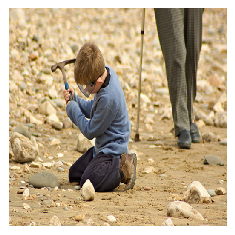

In [10]:

images, labels = next(iter(data_loader))
plot = func_imshow(images[0], normalize=False)

## Target Image

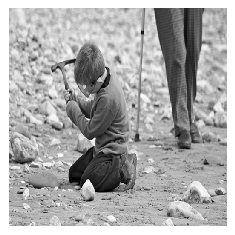

In [11]:

plot = func_imshow(images[0], normalize=False,gray=True)

## Defining AutoEncoder

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(3, 128 , 3, padding=1)  
        self.conv2 = nn.Conv2d(128, 32, 3, padding=1)
#         self.conv3 = nn.Conv2d(32, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.t_conv1 = nn.Conv2d(32, 8, 3, padding=1) 
        self.t_conv2 = nn.Conv2d(8, 16, 3, padding=1)
#         self.t_conv3 = nn.Conv2d(32, 128, 3, padding=1)
        self.conv_out = nn.Conv2d(16, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
#         print(x.shape)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
#         print(x.shape)
        x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         print(x.shape)
#         x = F.relu(self.conv3(x))
#         x = self.pool(x)
#         print(x.shape)
#         print("Start Decoder")
        
        ## decode ##
#         x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.relu(self.t_conv1(x))
        
#         print(x.shape)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.relu(self.t_conv2(x))
        
#         print(x.shape)
#         x = F.upsample(x, scale_factor=2, mode='nearest')
#         x = F.relu(self.t_conv3(x))
        
#         print(x.shape)
#         x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.sigmoid(self.conv_out(x))
#         print(x.shape)
                
        return x

# initialize the NN
model = AutoEncoder()
if use_cuda:
    model.cuda()
print(model)

AutoEncoder(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [13]:
# specify loss function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 30

In [14]:
### retraining Code total 250 times

In [ ]:
for epoch in range(1, n_epochs+1):
    # monitor training loss
    data_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in data_loader:
        # _ stands in for labels, here
        images, _ = data
        if use_cuda:
            images=images.cuda()
        
        ## Converting Image to grayscale
        gray_image = torch.tensor([cv2.cvtColor(i.cpu().numpy().transpose((1,2,0)), cv2.COLOR_RGB2GRAY) for i in images])
        
        if use_cuda:
            gray_image=gray_image.cuda()
        optimizer.zero_grad()
        
        outputs = model(images)

        loss = criterion(outputs, gray_image.reshape(-1,1,image_size,image_size))
        loss.backward()
        optimizer.step()
        data_loss += loss.item()*images.size(0)
            
    data_loss = data_loss/len(data_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        data_loss
        ))

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 1.216449
Epoch: 2 	Training Loss: 0.910838
Epoch: 3 	Training Loss: 0.298579
Epoch: 4 	Training Loss: 0.202595
Epoch: 5 	Training Loss: 0.111105
Epoch: 6 	Training Loss: 0.083428
Epoch: 7 	Training Loss: 0.072421
Epoch: 8 	Training Loss: 0.064682
Epoch: 9 	Training Loss: 0.059305
Epoch: 10 	Training Loss: 0.054896
Epoch: 11 	Training Loss: 0.053675
Epoch: 12 	Training Loss: 0.050572
Epoch: 13 	Training Loss: 0.049458
Epoch: 14 	Training Loss: 0.045219
Epoch: 15 	Training Loss: 0.043885
Epoch: 16 	Training Loss: 0.043335


In [ ]:
torch.save(model.state_dict(), '../working/model_RGB_GREY_15122019.state')

In [ ]:

model.load_state_dict(torch.load('../working/model_RGB_GREY_15122019.state'))

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images.cuda())
# prep images for display
images1 = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 512, 512)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()



In [ ]:
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,figsize=(35,35))

# input images on top row, reconstructions on bottom
for imagess, row in zip([images1, output], axes):
    for img, ax in zip(imagess, row):
        print(np.squeeze(img).shape)
        ax.imshow(np.squeeze(img.transpose((1,2,0))),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [ ]:
# gray_image =([cv2.cvtColor(i.transpose((1,2,0)), cv2.COLOR_RGB2GRAY) for i in images]).reshape(-1,1,image_size,image_size)
# gray_image.reshape(-1,1,image_size,image_size).shape

plot = func_imshow(images[1], normalize=False,gray=True)

In [ ]:
# !ls ../input/model-r-g/

In [ ]:
# model1 = AutoEncoder()
# model1.load_state_dict(torch.load(open('../input/model-r-g/model_RGB_GREY.state','rb'), map_location='cpu'))